In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from dataclasses import dataclass


In [3]:
@dataclass
class NeuronParams:
    tau_m: float = 10.0 # Membrane time constant
    E_L: float = -65.0 # Leak reversal potential
    R_m: float = 10.0 # Membrane resistance
    V_th: float = -50.0 # Spike threshold
    V_reset: float = -65.0 # Reset potential
    V_peak: float = 0.0 # Spike peak potential

@dataclass
class SynapseParams:
    tau_s: float = 5.0 # Synaptic time constant
    g_bar: float = 0.05 # Maximum synaptic conductance
    P_max: float = 1.0 # Maximum synaptic probability
    E_s: float = 0.0 # Reversal potential


In [4]:
class Synapse:
    def __init__(self, params: SynapseParams):
        self.params = params
        self.P = 0.0

    def step(self, spike: bool, dt: float):
        # decay
        self.P -= (self.P / self.params.tau_s) * dt
        # jump on presynaptic spike
        if spike:
            self.P += self.params.P_max * (1.0 - self.P)
        return self.P

class Neuron:
    def __init__(self, params: NeuronParams, dt: float):
        self.p = params
        self.dt = dt
        self.V = params.E_L
        
    def dVdt(self, V: float, I_ext: float, syn_cond: float, E_s: float) -> float:
        leak = self.p.E_L - V
        syn_current = - self.p.R_m * syn_cond * (V - E_s)
        total_input = leak + syn_current + self.p.R_m * I_ext
        return total_input / self.p.tau_m
    
    def rk4_step(self, I_ext: float, syn_cond: float, E_s: float):
        k1 = self.dVdt(self.V, I_ext, syn_cond, E_s) * self.dt
        k2 = self.dVdt(self.V + 0.5 * k1, I_ext, syn_cond, E_s) * self.dt
        k3 = self.dVdt(self.V + 0.5 * k2, I_ext, syn_cond, E_s) * self.dt
        k4 = self.dVdt(self.V + k3, I_ext, syn_cond, E_s) * self.dt
        return self.V + (k1 + 2*k2 + 2*k3 + k4) / 6.0

    def step(self, I_ext: float, syn: Synapse, E_s: float):
        V_next = self.rk4_step(I_ext, syn.P * syn.params.g_bar, E_s)
        if V_next >= self.p.V_th:
            self.V = self.p.V_reset
            return True, self.p.V_peak
        else:
            self.V = V_next
            return False, V_next


In [5]:
def simulate(E_s_ab, P_s_ab, E_s_ba, P_s_ba, time, I_A, I_B, dt):
    neuron_A = Neuron(NeuronParams(), dt)
    neuron_B = Neuron(NeuronParams(), dt)
    syn_AtoB = Synapse(SynapseParams(E_s=E_s_ab, P_max=P_s_ab))
    syn_BtoA = Synapse(SynapseParams(E_s=E_s_ba, P_max=P_s_ba))

    V_A = np.full_like(time, neuron_A.p.E_L)
    V_B = np.full_like(time, neuron_B.p.E_L)
    P_s_ab_trace = np.zeros_like(time)
    P_s_ba_trace = np.zeros_like(time)

    for i in range(1, len(time)):
        spike_A, V_A[i] = neuron_A.step(I_A[i], syn_BtoA, E_s_ba)
        P_s_ab_trace[i] = syn_AtoB.step(spike_A, dt)
        spike_B, V_B[i] = neuron_B.step(I_B[i], syn_AtoB, E_s_ab)
        P_s_ba_trace[i] = syn_BtoA.step(spike_B, dt)

    return V_A, V_B, P_s_ab_trace, P_s_ba_trace


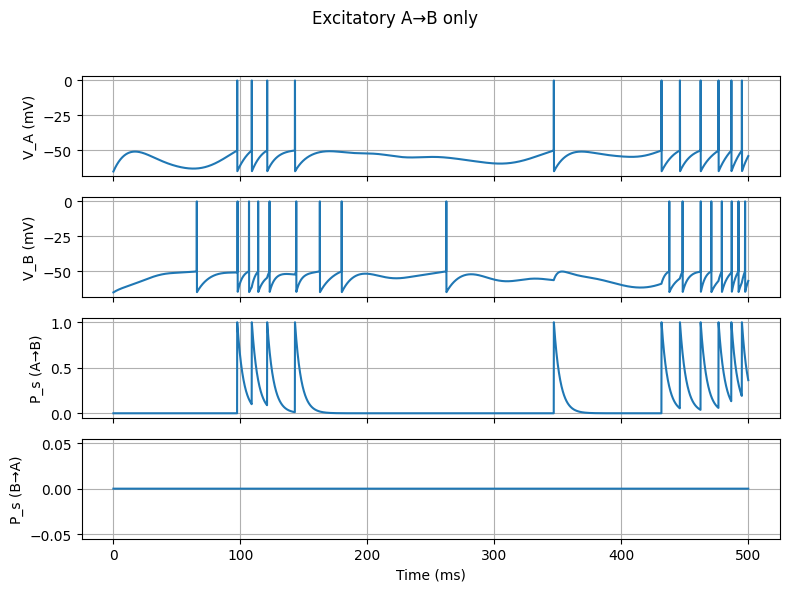

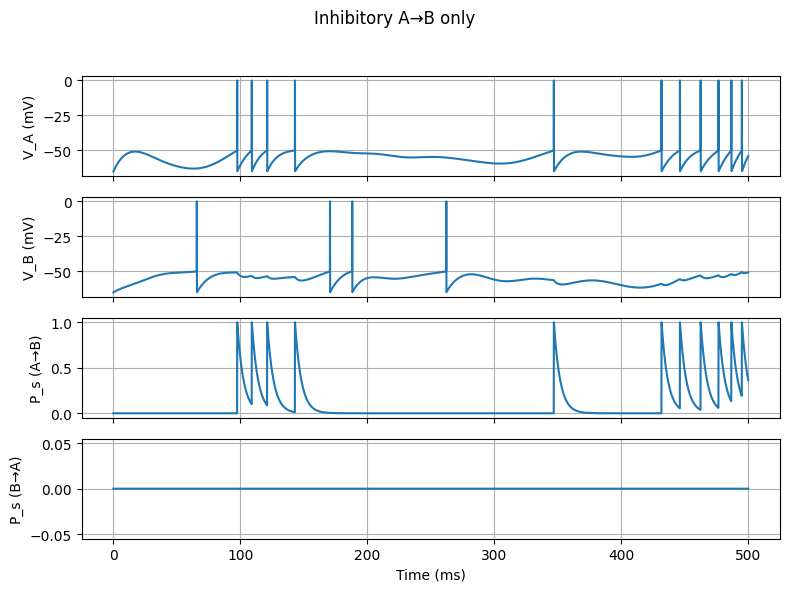

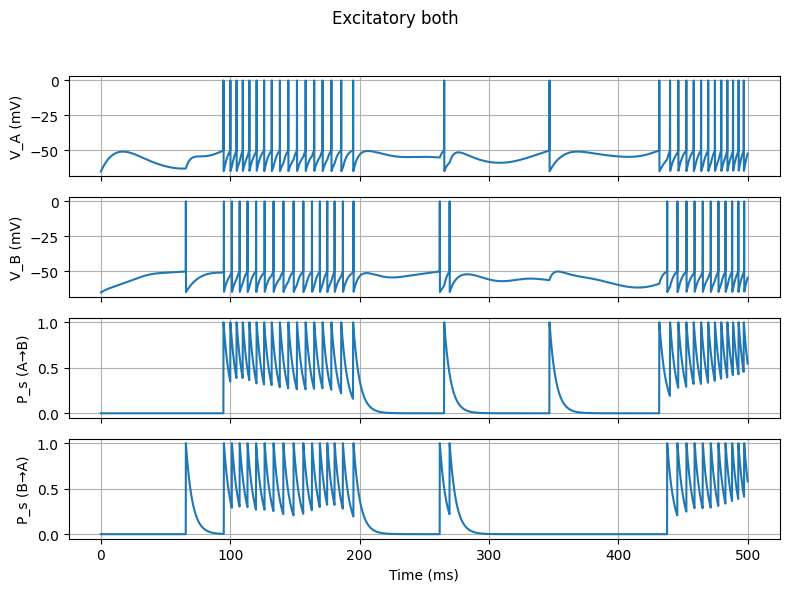

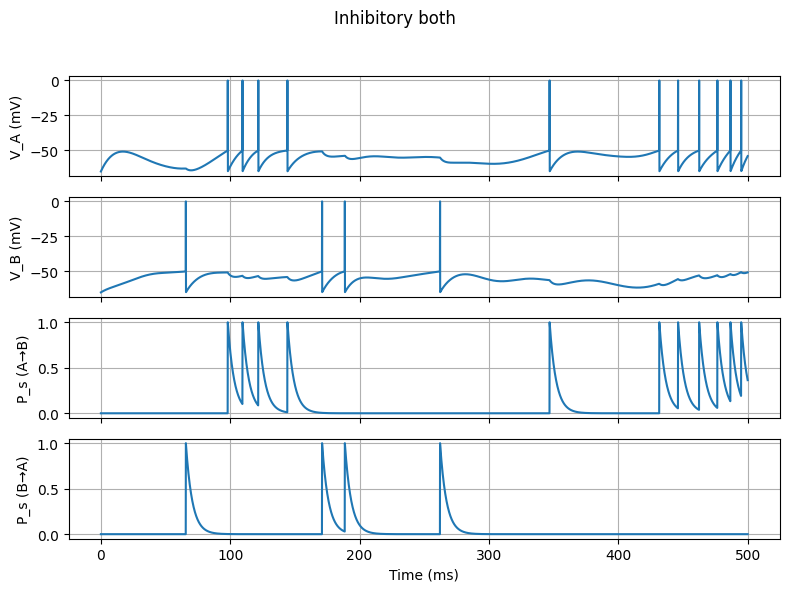

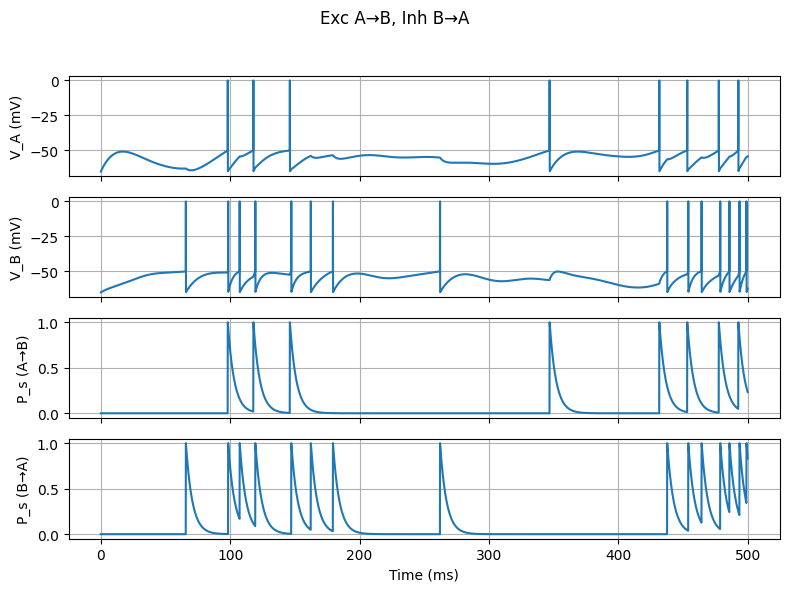

In [6]:
dt = 0.1
T = 500
time = np.arange(0, T + dt, dt)
np.random.seed(0)
I_A = 1.5 + gaussian_filter1d(np.random.randn(len(time)), sigma=150) * 12
I_B = 1.5 + gaussian_filter1d(np.random.randn(len(time)), sigma=150) * 12

scenarios = [
    ("Excitatory A→B only",      0.0,  1.0,  0.0, 0.0),
    ("Inhibitory A→B only",     -80.0, 1.0,  0.0, 0.0),
    ("Excitatory both",          0.0,  1.0,  0.0, 1.0),
    ("Inhibitory both",         -80.0, 1.0, -80.0, 1.0),
    ("Exc A→B, Inh B→A",         0.0,  1.0, -80.0, 1.0),
]

for label, E_ab, P_ab, E_ba, P_ba in scenarios:
    V_A, V_B, P_ab_trace, P_ba_trace = simulate(E_ab, P_ab, E_ba, P_ba, time, I_A, I_B, dt)

    fig, axes = plt.subplots(4, 1, figsize=(8, 6), sharex=True)
    fig.suptitle(label)

    axes[0].plot(time, V_A); axes[0].set_ylabel('V_A (mV)')
    axes[1].plot(time, V_B); axes[1].set_ylabel('V_B (mV)')
    axes[2].plot(time, P_ab_trace); axes[2].set_ylabel('P_s (A→B)')
    axes[3].plot(time, P_ba_trace); axes[3].set_ylabel('P_s (B→A)')
    axes[3].set_xlabel('Time (ms)')

    for ax in axes:
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [ ]:
def simulate_full(E_s_ab, P_s_ab, E_s_ba, P_s_ba, time, I_A, I_B, dt, 
                  tau_s:float = 5.0, 
                  g_bar:float = 0.05, 
                  tau_m:float = 10.0, 
                  E_L:float = -65, 
                  R_m:float = 10.0, 
                  V_th:float = -50, 
                  V_reset:float = -65, 
                  V_peak:float = 0):
    neuron_A = Neuron(NeuronParams(tau_m=tau_m, E_L=E_L, R_m=R_m, V_th=V_th, V_reset=V_reset, V_peak=V_peak), dt)
    neuron_B = Neuron(NeuronParams(tau_m=tau_m, E_L=E_L, R_m=R_m, V_th=V_th, V_reset=V_reset, V_peak=V_peak), dt)
    syn_AtoB = Synapse(SynapseParams(tau_s=tau_s, g_bar=g_bar, P_max=P_s_ab, E_s=E_s_ab))
    syn_BtoA = Synapse(SynapseParams(tau_s=tau_s, g_bar=g_bar, P_max=P_s_ba, E_s=E_s_ba))

    V_A = np.full_like(time, neuron_A.p.E_L)
    V_B = np.full_like(time, neuron_B.p.E_L)
    P_s_ab_trace = np.zeros_like(time)
    P_s_ba_trace = np.zeros_like(time)

    for i in range(1, len(time)):
        spike_A, V_A[i] = neuron_A.step(I_A[i], syn_BtoA, E_s_ba)
        P_s_ab_trace[i] = syn_AtoB.step(spike_A, dt)
        spike_B, V_B[i] = neuron_B.step(I_B[i], syn_AtoB, E_s_ab)
        P_s_ba_trace[i] = syn_BtoA.step(spike_B, dt)

    return V_A, V_B, P_s_ab_trace, P_s_ba_trace


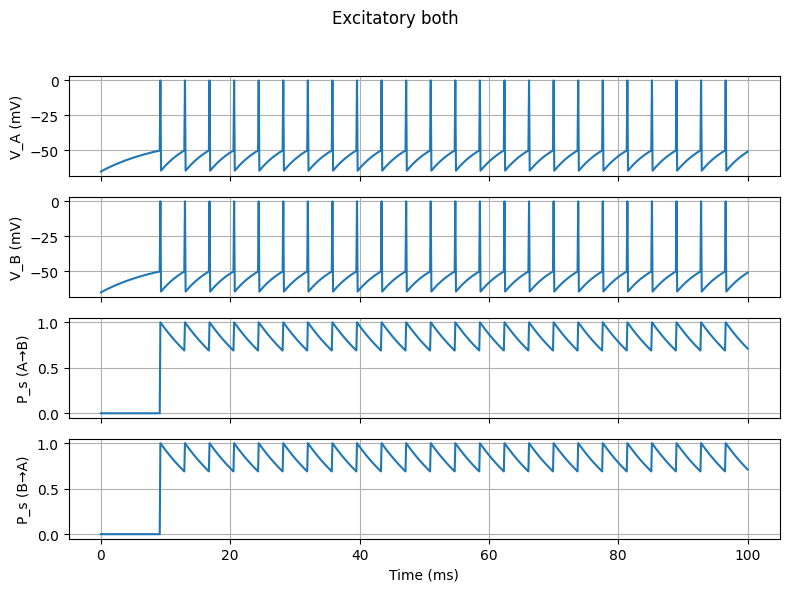

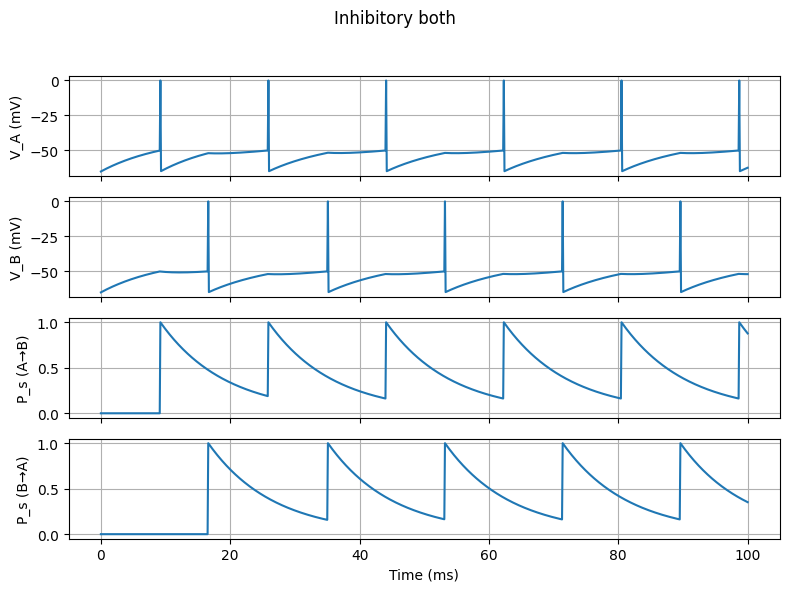

In [8]:
dt = 0.1
T = 100
time = np.arange(0, T + dt, dt)
I_A = np.ones_like(time) * 2.5
I_B = np.ones_like(time) * 2.5

tau_s = 10
scenarios = [
    ("Excitatory both",          0.0,  1.0,  0.0, 1.0),
    ("Inhibitory both",         -80.0, 1.0, -80.0, 1.0),
]

for label, E_ab, P_ab, E_ba, P_ba in scenarios:
    V_A, V_B, P_ab_trace, P_ba_trace = simulate_full(E_ab, P_ab, E_ba, P_ba, time, I_A, I_B, dt, tau_s=tau_s)

    fig, axes = plt.subplots(4, 1, figsize=(8, 6), sharex=True)
    fig.suptitle(label)

    axes[0].plot(time, V_A); axes[0].set_ylabel('V_A (mV)')
    axes[1].plot(time, V_B); axes[1].set_ylabel('V_B (mV)')
    axes[2].plot(time, P_ab_trace); axes[2].set_ylabel('P_s (A→B)')
    axes[3].plot(time, P_ba_trace); axes[3].set_ylabel('P_s (B→A)')
    axes[3].set_xlabel('Time (ms)')

    for ax in axes:
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


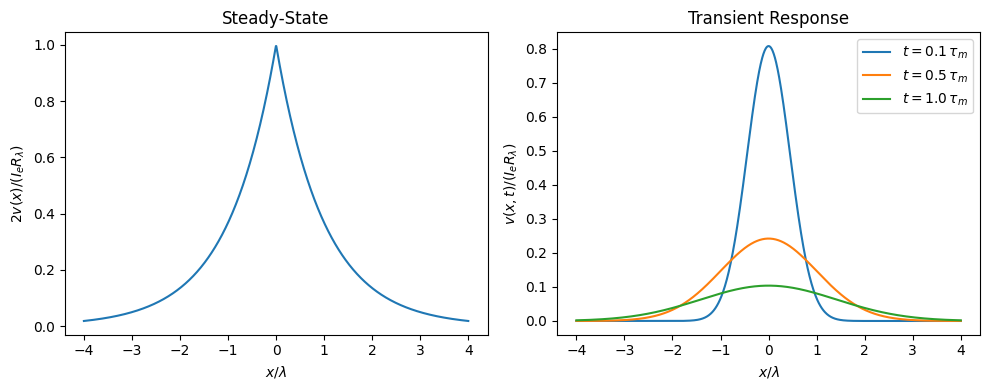

In [ ]:
I_e = 1.0        # injected current
R_lambda = 1.0   # input resistance
tau_m = 1.0      # membrane time constant
lambda_e = 1.0   # electrotonic length constant

# Spatial coordinate in units of lambda
x = np.linspace(-4 * lambda_e, 4 * lambda_e, 1000) / lambda_e

# Static solution
v_static = (I_e * R_lambda / 2) * np.exp(-np.abs(x))

# Time‐dependent solution
times = [0.1 * tau_m, .5 * tau_m, 1 * tau_m]
# times = [0.1 * tau_m, 1 * tau_m, 2 * tau_m]
v_dyn = {}
for t in times:
    tau = t / tau_m
    v_dyn[t] = (I_e * R_lambda 
                / np.sqrt(4 * np.pi * tau)) \
               * np.exp(-x**2 / (4 * tau)) * np.exp(-tau)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(x, 2 * v_static / (I_e * R_lambda))
ax1.set_title('Steady‐State')
ax1.set_xlabel('$x/\\lambda$')
ax1.set_ylabel('$2v(x)/(I_e R_\\lambda)$')
ax1.grid(False)

for t in times:
    ax2.plot(x, v_dyn[t] / (I_e * R_lambda), label=f'$t={t/ tau_m}\\,\\tau_m$')
ax2.set_title('Transient Response')
ax2.set_xlabel('$x/\\lambda$')
ax2.set_ylabel('$v(x,t)/(I_e R_\\lambda)$')
ax2.legend(loc='upper right')
ax2.grid(False)

plt.tight_layout()
plt.show()


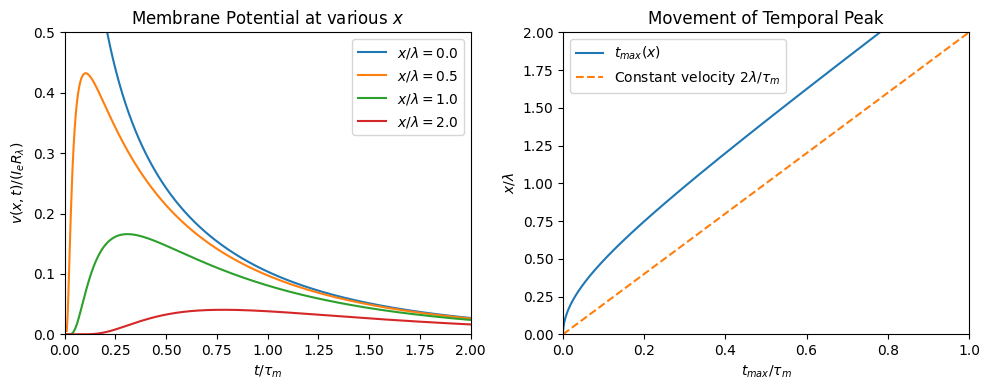

In [ ]:
I_e = 1.0        # injected current
R_lambda = 1.0   # input resistance
tau_m = 1.0      # membrane time constant
lambda_e = 1.0   # electrotonic length constant

taus = np.linspace(0.01, 2.0, 500)
x_positions = np.array([0.0, 0.5, 1.0, 2.0])

v_xt = {}
for x in x_positions:
    v_xt[x] = (1/np.sqrt(4 * np.pi * taus)
               * np.exp(-x**2 / (4 * taus))
               * np.exp(-taus))

xs = np.linspace(0.0, 2.0, 500)
tau_max = (np.sqrt(1 + 4 * xs**2) - 1) / 4

tau_line = np.linspace(0.0, 1.0, 500)
x_line = 2 * tau_line

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for x in x_positions:
    ax1.plot(taus, v_xt[x], label=f'$x/\\lambda={x}$')
ax1.set_title('Membrane Potential at various $x$')
ax1.set_xlabel('$t/\\tau_m$')
ax1.set_ylabel('$v(x,t)/(I_e R_\\lambda)$')
ax1.set_xlim(0, 2)
ax1.set_ylim(0, 0.5)
ax1.legend()
ax1.grid(False)

# peak-time locus
ax2.plot(tau_max, xs, label='$t_{max}(x)$')
ax2.plot(tau_line, x_line, '--', label='Constant velocity $2\\lambda/\\tau_m$')
ax2.set_title('Movement of Temporal Peak')
ax2.set_xlabel('$t_{max}/\\tau_m$')
ax2.set_ylabel('$x/\\lambda$')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 2)
ax2.legend()
ax2.grid(False)

plt.tight_layout()
plt.show()
